INFO: Mengimpor library yang dibutuhkan...
✅ Library berhasil diimpor.

INFO: Memuat dataset dari file CSV...
✅ Dataset berhasil dimuat. Terdapat 1000 baris data.

--- Memulai Analisis Eksploratif Data (EDA) ---

Informasi dasar dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               1000 non-null   object
 1   label              1000 non-null   int64 
 2   sumber             1000 non-null   object
 3   kategori_penipuan  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


/tmp/ipykernel_349818/1417845064.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=['#4CAF50', '#F44336'])


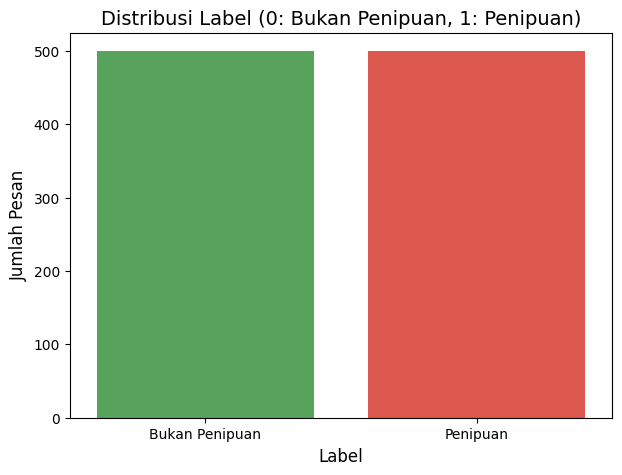

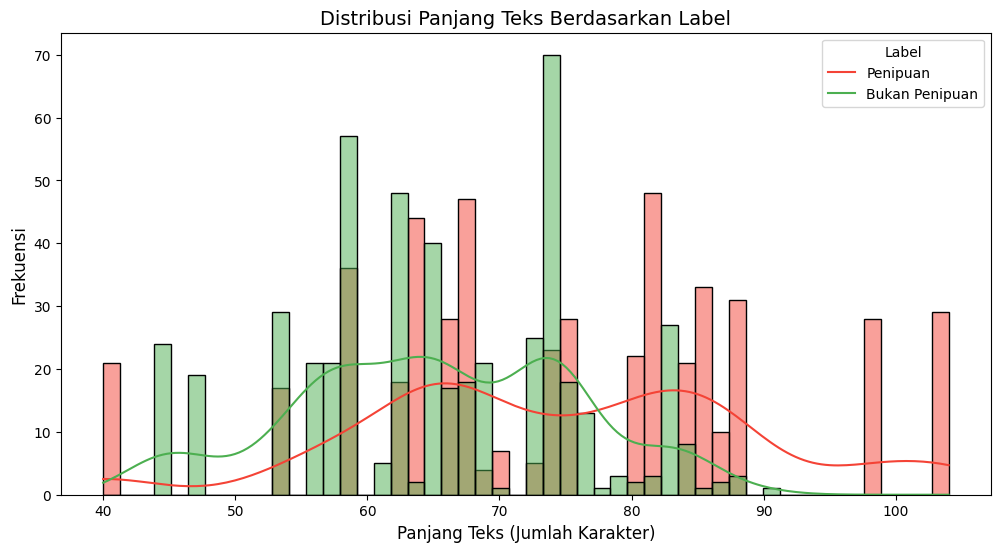


--- Memulai Pra-pemrosesan Teks ---
INFO: Mendownload stopwords NLTK...


[nltk_data] Downloading package stopwords to /home/v8/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


✅ Pra-pemrosesan teks selesai.

INFO: Membuat visualisasi WordCloud...


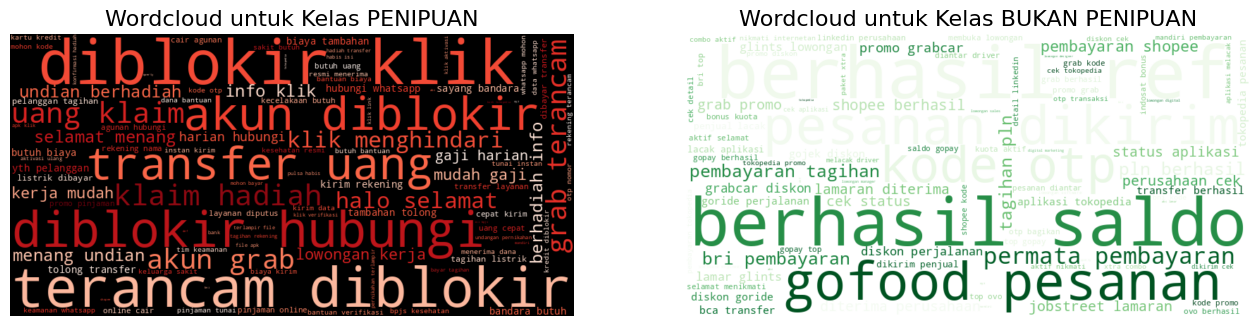


--- Memulai Ekstraksi Fitur dan Pemodelan ---

Ukuran matriks TF-IDF untuk data latih: (800, 382)
✅ Model Logistic Regression berhasil dilatih.

--- Mengevaluasi Performa Model ---

Laporan Klasifikasi:
                    precision    recall  f1-score   support

Bukan Penipuan (0)       1.00      1.00      1.00       100
      Penipuan (1)       1.00      1.00      1.00       100

          accuracy                           1.00       200
         macro avg       1.00      1.00      1.00       200
      weighted avg       1.00      1.00      1.00       200



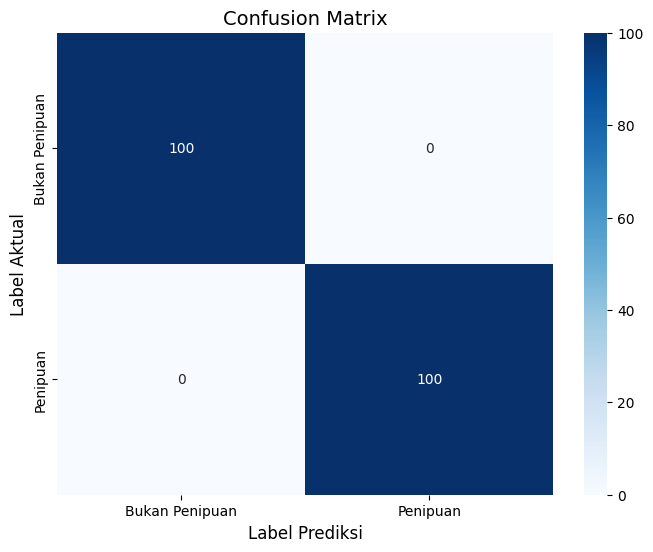


--- Menganalisis Kesalahan Prediksi ---
Model membuat 0 kesalahan dari 200 data uji.

Contoh False Positive (Pesan Sah Dianggap Penipuan):
Empty DataFrame
Columns: [text, label_aktual, label_prediksi]
Index: []

Contoh False Negative (Pesan Penipuan Dianggap Sah):
Empty DataFrame
Columns: [text, label_aktual, label_prediksi]
Index: []

--- Menyimpan model dan vectorizer untuk deployment ---
✅ Model dan TF-IDF Vectorizer telah disimpan di folder 'saved_models/'.

🏁 SEMUA TAHAP ANALISIS DAN PEMODELAN SELESAI! 🏁


In [1]:
# ==============================================================================
# PROYEK DETEKSI PENIPUAN LINGUISTIK - NOTEBOOK ANALISIS & PEMODELAN
# ==============================================================================

# --- Langkah 1: Impor Library Utama ---
print("INFO: Mengimpor library yang dibutuhkan...")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os
print("✅ Library berhasil diimpor.")

# --- Langkah 2: Memuat Dataset ---
print("\nINFO: Memuat dataset dari file CSV...")
DATA_PATH = '../data/dataset_penipuan.csv'

try:
    df = pd.read_csv(DATA_PATH)
    print(f"✅ Dataset berhasil dimuat. Terdapat {len(df)} baris data.")
except FileNotFoundError:
    print(f"❌ ERROR: File tidak ditemukan di '{DATA_PATH}'. Pastikan file CSV Anda ada di folder 'data/'.")
    exit()

# --- Langkah 3: Analisis Eksploratif Data (EDA) ---
print("\n--- Memulai Analisis Eksploratif Data (EDA) ---")

# Menampilkan info dasar dan data kosong
print("\nInformasi dasar dataset:")
df.info()

# Distribusi Label
plt.figure(figsize=(7, 5))
sns.countplot(x='label', data=df, palette=['#4CAF50', '#F44336'])
plt.title('Distribusi Label (0: Bukan Penipuan, 1: Penipuan)', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Jumlah Pesan', fontsize=12)
plt.xticks([0, 1], ['Bukan Penipuan', 'Penipuan'])
plt.show()

# Distribusi Panjang Teks
df['panjang_teks'] = df['text'].str.len()
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='panjang_teks', hue='label', bins=50, kde=True, palette=['#4CAF50', '#F44336'])
plt.title('Distribusi Panjang Teks Berdasarkan Label', fontsize=14)
plt.xlabel('Panjang Teks (Jumlah Karakter)', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.legend(title='Label', labels=['Penipuan', 'Bukan Penipuan'])
plt.show()

# --- Langkah 4: Pra-pemrosesan Teks ---
print("\n--- Memulai Pra-pemrosesan Teks ---")

# Download stopwords Bahasa Indonesia dari NLTK (aman untuk dijalankan berulang kali)
try:
    stopwords_indonesia = stopwords.words('indonesian')
except LookupError:
    print("INFO: Mendownload stopwords NLTK...")
    nltk.download('stopwords')
    stopwords_indonesia = stopwords.words('indonesian')

# Tambahkan beberapa stopwords kustom yang sering muncul namun tidak informatif
stopwords_indonesia.extend(['yg', 'dg', 'dgn', 'dr', 'kpd', 'utk', 'kak', 'gan', 'sis'])

def preprocess_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()  # Lowercasing
    text = re.sub(r'\[.*?\]', '', text)  # Hapus placeholder seperti [NOMOR_REKENING]
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Hapus URL
    text = re.sub(r'<.*?>+', '', text)  # Hapus tag HTML
    text = re.sub(r'[^\w\s]', ' ', text)  # Ganti tanda baca dengan spasi
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = ' '.join(word for word in text.split() if word not in stopwords_indonesia and len(word) > 2) # Hapus stopwords & kata pendek
    return text.strip()

df['text_bersih'] = df['text'].astype(str).apply(preprocess_text)
print("✅ Pra-pemrosesan teks selesai.")

# Menampilkan WordCloud untuk visualisasi kata
print("\nINFO: Membuat visualisasi WordCloud...")
penipuan_text = ' '.join(df[df['label'] == 1]['text_bersih'])
bukan_penipuan_text = ' '.join(df[df['label'] == 0]['text_bersih'])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
wordcloud_penipuan = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(penipuan_text)
plt.imshow(wordcloud_penipuan, interpolation='bilinear')
plt.title('Wordcloud untuk Kelas PENIPUAN', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_bukan_penipuan = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(bukan_penipuan_text)
plt.imshow(wordcloud_bukan_penipuan, interpolation='bilinear')
plt.title('Wordcloud untuk Kelas BUKAN PENIPUAN', fontsize=16)
plt.axis('off')

plt.show()

# --- Langkah 5: Ekstraksi Fitur & Pemodelan ---
print("\n--- Memulai Ekstraksi Fitur dan Pemodelan ---")

# Inisialisasi TF-IDF Vectorizer
# Menggunakan n-gram (1,2) untuk menangkap frasa 1 kata dan 2 kata
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Membagi data menjadi data latih dan data uji
X = df['text_bersih']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit dan transform TF-IDF hanya pada data latih
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# Transformasi data uji menggunakan vectorizer yang sama
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nUkuran matriks TF-IDF untuk data latih: {X_train_tfidf.shape}")

# Melatih model Logistic Regression
# class_weight='balanced' penting untuk menangani jika ada ketidakseimbangan kelas
model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
model.fit(X_train_tfidf, y_train)
print("✅ Model Logistic Regression berhasil dilatih.")

# Melakukan prediksi pada data uji
y_pred = model.predict(X_test_tfidf)

# --- Langkah 6: Evaluasi Performa Model ---
print("\n--- Mengevaluasi Performa Model ---")

# Laporan Klasifikasi
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=['Bukan Penipuan (0)', 'Penipuan (1)']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bukan Penipuan', 'Penipuan'], 
            yticklabels=['Bukan Penipuan', 'Penipuan'])
plt.ylabel('Label Aktual', fontsize=12)
plt.xlabel('Label Prediksi', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.show()

# --- Langkah 7: Analisis Kesalahan (Error Analysis) ---
print("\n--- Menganalisis Kesalahan Prediksi ---")

# Membuat DataFrame untuk analisis kesalahan
df_test_results = X_test.to_frame(name='text')
df_test_results['label_aktual'] = y_test
df_test_results['label_prediksi'] = y_pred

kesalahan = df_test_results[df_test_results['label_aktual'] != df_test_results['label_prediksi']]
print(f"Model membuat {len(kesalahan)} kesalahan dari {len(df_test_results)} data uji.")

# Menampilkan beberapa contoh False Positive (Aktual: 0, Prediksi: 1)
print("\nContoh False Positive (Pesan Sah Dianggap Penipuan):")
pd.set_option('display.max_colwidth', None) # Agar teks penuh terlihat
print(kesalahan[kesalahan['label_aktual'] == 0].head())

# Menampilkan beberapa contoh False Negative (Penipuan Dianggap Sah)
print("\nContoh False Negative (Pesan Penipuan Dianggap Sah):")
print(kesalahan[kesalahan['label_aktual'] == 1].head())

# --- Langkah 8: Menyimpan Model dan Vectorizer ---
print("\n--- Menyimpan model dan vectorizer untuk deployment ---")

# Membuat folder jika belum ada
if not os.path.exists('../saved_models'):
    os.makedirs('../saved_models')

# Menyimpan model dan vectorizer menggunakan joblib
joblib.dump(model, '../saved_models/model.pkl')
joblib.dump(tfidf_vectorizer, '../saved_models/tfidf_vectorizer.pkl')

print("✅ Model dan TF-IDF Vectorizer telah disimpan di folder 'saved_models/'.")
print("\n🏁 SEMUA TAHAP ANALISIS DAN PEMODELAN SELESAI! 🏁")